In [21]:
import pandas as pd
import plotly.express as px
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [9]:
# Loading dataset
data_path = 'B:/_GITHUB/Data-Science-Projects/Tiktok_Review_analysis/dataset/tiktok_google_play_reviews.csv'
data = pd.read_csv(data_path)

In [10]:
print(data)

                                                 reviewId        userName  \
0       gp:AOqpTOHRz-11c0apHLSKHHp52FxUXsQS9Z88wP3sWc5...    MR LOL GAMER   
1       gp:AOqpTOF6mFDEkIypmyT3shDLjPHg8zB3kdns2W36ahp...     Dino Kljako   
2       gp:AOqpTOGtqU4sb8vuVo3-eB7kIXWoBn-0YCUZ1SnPRKS...  Olivia Harding   
3       gp:AOqpTOFHDm-Qa5R6jCpOGTFT2qr1_PKbCTbBNPahCEn...         Keli We   
4       gp:AOqpTOFB6Ndao8IHRpOJRmbSknwMGxHcwYzux93YyXI...    Mavis Kotoka   
...                                                   ...             ...   
307052  gp:AOqpTOEX2qzcEhnamYxu8Jrnu4Ia0UtuHkajx6I1Y_j...     Nze Alpeace   
307053  gp:AOqpTOHnBTSFCqxFYSsNrg4vztYn-Z0Gg3aCIGLliRK...   Shalina Sayed   
307054  gp:AOqpTOEuzjdo0NhbqpSBB18hhKP8X6FNPDOWVsan_TA...   ntokozo zondi   
307055  gp:AOqpTOFoaOhvxddyVQPQJHpv9f4kgn2u2kkniAWQTRM...     Asika Emeka   
307056  gp:AOqpTOF_2SyR6RmxASgEiW-4Vw9QRwF4sybqcSdnTlq...   Sumaiya Islam   

                                                userImage  \
0       https:

The dataset contains, 10 columns with different values some of which we would not use since we
are analyzing the reviews on TikTok, the two crucials tables here would be be _"score"_ and 
_"content"_. Thus we can build a new dataset with those columns.

In [11]:
data = data[['content','score']]
print(data.head(5))

                                             content  score
0                                               Good      5
1  Awesome app! Too many people on it where it's ...      5
2                                            Not bad      5
3                                         It is good      2
4                               Very interesting app      5


In [12]:
# check for null value and drop any 
print('Before droping null values: \n',data.isnull().sum())
data = data.dropna()
print('After droping null values: \n',data.isnull().sum())

Before droping null values: 
 content    4
score      0
dtype: int64
After droping null values: 
 content    0
score      0
dtype: int64


In [13]:
# Data cleaning
stopword = set(stopwords.words("english"))
stemmer = nltk.SnowballStemmer("english")
# print(stopword)
def preprocess(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text
data['content'] = data['content'].apply(preprocess)
# print(data['content'])

In [14]:
ratings = data['score'].value_counts()
index = ratings.index
fig = px.pie(data, values=ratings, names=index, hole = 0.5)
fig.update_layout(title = 'Ratings distribution', title_x=0.5, height= 500, width = 800)
fig.show()

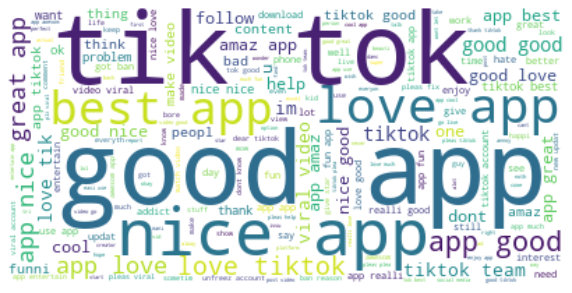

In [38]:
# checking most frequently used words
text = ' '.join(content for content in data.content)
# print(text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords, background_color = 'white').generate(text)
plt.figure(figsize=(10,15))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()